In [1]:
# Needs hdf5 to run
# Instead of hf datasets lib alternatively use torchgeo
# As of 02.11.24 failed to reach geo API, could attempt later
%pip install --upgrade torch;
%pip install --upgrade torchvision;
%pip install --upgrade datasets;
%pip install --upgrade h5py;
%pip install --upgrade kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


In [2]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import json
import csv
import logging
import tqdm
import torch
import datasets
from datasets.combine import *
import PIL
from collections import OrderedDict
import time
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from timm import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
from torchvision.transforms.v2 import functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
from kornia import filters
import kornia.augmentation as K


# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually


_URLS = {'root': os.curdir,'cache_dir':"raw"}
_BATCH_SIZE = 16
_NUM_WORKERS = 2
_TRAIN_SPLIT = {'d1':'chabud','d2':3,'d3':4}
_VALID_SPLIT = '2'
_TEST_SPLIT = "1"


Тут можна задати спліти 0-4, що дає вчитися і перевіряти метрики на незалежних вибірках



In [3]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])
sys.path.append(os.path.abspath('..'))

# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

HF_DATASETS_CACHE set to: ./raw


In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

In [5]:
# Load the CaBuAr dataset
# Possible splits: 1-5, or chabud
# For docs check out
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar
d1 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d1']}", trust_remote_code=True)
d2 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d2']}", trust_remote_code=True)
d3 = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f"{_TRAIN_SPLIT['d3']}", trust_remote_code=True)

train_data = interleave_datasets([d1, d2, d3], stopping_strategy='all_exhausted')
valid_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_VALID_SPLIT}',trust_remote_code=True)
test_data = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split=f'{_TEST_SPLIT}',trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

california_burned_areas.py:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

512x512.hdf5:   0%|          | 0.00/5.88G [00:00<?, ?B/s]

chabud_test.h5:   0%|          | 0.00/667M [00:00<?, ?B/s]

Generating 0 split: 0 examples [00:00, ? examples/s]

Generating 1 split: 0 examples [00:00, ? examples/s]

Generating 2 split: 0 examples [00:00, ? examples/s]

Generating 3 split: 0 examples [00:00, ? examples/s]

Generating 4 split: 0 examples [00:00, ? examples/s]

Generating chabud split: 0 examples [00:00, ? examples/s]

### На основі аналізу датасету запроповані рішення для перетворення датасету
 - Create an class ratio graphic in output mask

Бінарність класів спрощує Segmentation loss в просту бінарну кроссентропію з логітами.
 Використаємо взваження класів відносно їх частоти в зображенні всередині  лосс функції за допомогою class_weights.
Додаємо до BCE лосс-функції додатково Dice loss, що є диферренційованим F1 score

 - Mean brightness, distribution per-channel of images

Додамо першим шаром батч нормалізацію,

**Створимо синтез фіч**:
1.  порахувавши індекс щільності рослинності (NDVI): гіперболічну дистанцію між яскравістю пікселів Червоного (B04), Інфрачервоного (B08) каналів першим каналом,
2. А також для Довгих інфрачервоних DWDM каналів B12 і B11.

3. Останнім каналом візьмемо B09, для відокремлення вологого грунту
від спаленої землі і водних об'єктів.

Присутність великого набору семплів з пустими масками (class 0) підвищує захищеність моделі

Для зменшення шуму окремо згладимо вхідне зображення з Гауссовим блюром

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed?

Так як не присутня залежність між зображеннями в батчі, регуляризація виконується для кожної пари вхідне зображення --- маска:

1. До вхідного зображення додається невелика кількість шуму

2. З RandomJigsaw синхронно розрізаємо зображення та маску на квадрати NxN і перемішуємо їх

3. Під час тренування для одночасно маски і зображення робимо афінне перетворення, відображаємо вертикально та горизонтально

Ціллю є підвищення інваріантності по переміщенню і обертанню, подальше використання dropout для зменшення глобальних глобальних активацій нейронів, і більшого фокусу моделі на локальних фічах, інваріантно від топографії ландшафту і присутніх на ньому географічних ознак.

## Preprocessing functions



- Hyperbolic difference

Відображає нелінійний ріст залежності, накладає вагу для збільшення контрасту між схожими значеннями і аутлаєрами, додає біас.

- Canny (не використовується)

Детектор країв, надає оцінку по найбільш вираженому градієнт на зображенні.

In [6]:
def compute_difference(pre_fire, post_fire):
    return post_fire - pre_fire

def hyperbolic_diff(img_x, img_y, scale = 0.5, bias = 0):
    if bias == -1e-6:
        bias = 0
    return scale * (img_x - img_y) / (img_x + img_y + bias + 1e-6)


def canny(image, lo=0.1, hi=0.2):
        return filters.canny(image, low_threshold=lo, high_threshold=hi)

def clip_values(image, min_val=0.0, max_val=1.0):
    return torch.clamp(image, min=min_val, max=max_val)

def unsharp(image):
    return filters.unsharp_maskkernel_size(image, (3, 3), sigma=(0.1, 2.0), border_type='refect')

def rearrange_channels(pre_fire, post_fire):
    # Stack pre-fire and post-fire channels
    return torch.cat([pre_fire, post_fire], dim=1)  # Shape: [Batch, 24, H, W]

Перетворення листків датасету в тензори toTensor замінено на torch.tensor()

- Transform виконується одночасно на вхідному зображенні і масці; стосується лише афінних перетворень без зміни кольорів

- Augmentation - лише для вхідного зображення post_fire - згладжує зображення для ідентифікації грубих фіч, видаляє частину інформації для підвищення робастності на реальному тестуванні

- Important to denoise the data,
 using gaussian blur pyramids

In [7]:
mozaic = K.RandomJigsaw((2, 2), keepdim=True, p=0.5)
# normalize = transforms.Normalize(mean=[0.485]*1, std=[0.229]*1)

gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
adjust_contrast = transforms.ColorJitter(contrast=1.5)

totensor = transforms.Compose([
            transforms.Lambda(np.array), # List converts to numpy array
            transforms.ToTensor(),
        ])

def get_transforms(size):
  return transforms.Compose([
    mozaic,
    transforms.RandomAffine(degrees=15., translate=(0.3, 0.3), interpolation=PIL.Image.BILINEAR),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop(size, pad_if_needed=True, padding_mode='reflect')
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

augmentation = transforms.Compose([
    # normalize,
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    # filters.Laplacian(kernel_size=(3, 3), border_type='reflect'),
    #K.RandomGaussianNoise(std=0.2,  p=0.5),
    # TODO reenable with batches enabled
    transforms.GaussianNoise(sigma=0.05),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    #filters.Laplacian(kernel_size=(3, 3), border_type='reflect'),
])



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


- Define scripts to convert image to 3 channel image
- Define clipping of class values
-  Normalization
- Showing before/after
- Resizing of images, important for  (Optional)

## Three channels
- (Natural Density of Vegetation, Water vapor intensity, medium-long infrared ratio)

- Розділяємо батч на окремі зображення (3, 512, 512) і маску (1, 512, 512)

Видалені канали:

- B01 - рівень аерозолю

- B02, 03 - зелений і синій, видима неозброєним оком рослинність і водойми

- B05-07 - Класифікація рослинних культур

- B10 - Тип хмар

- Всі інші канали крім B04, B08, B09, B11, B12 дропаємо для зменшення зайвого об'єму інформації поданого на вхід, і використання претренованих ваг.


In [12]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, augment=None):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.augment = augment


    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 8 and Red is channel 4 (0-indexed)
        # pre_nir = pre_fire[:, 7, :, :].unsqueeze(0)
        # pre_red = pre_fire[:, 3, :, :].unsqueeze(0)
        # post_nir = post_fire[:, 7, :, :].unsqueeze(0)
        # post_red = post_fire[:, 3, :, :].unsqueeze(0)
        pre_nir = pre_fire[7, :, :]
        pre_red = pre_fire[3, :, :]
        post_nir = post_fire[7, :, :]
        post_red = post_fire[3, :, :]
        # Compute hyperbolic difference of channels
        ndvi_pre = hyperbolic_diff(pre_nir, pre_red, scale=8.5)
        ndvi_post = hyperbolic_diff(post_nir, post_red, scale=8.5)

        # Return a mean square distance between old and new
        return torch.square(ndvi_post - ndvi_pre)
        #return ndvi_post


    def fire_boundary(self, post_fire, lo=0.1, hi=0.2):
        # Extract low frequency bands:
        # band_11 = post_fire[:, 10, :, :].unsqueeze(0)
        # band_12 = post_fire[:, 11, :, :].unsqueeze(0)
        band_11 = post_fire[10, :, :]
        band_12 = post_fire[11, :, :]

        return hyperbolic_diff(band_11, band_12, 8.5, 0.25)  # Shape: [1, H, W]

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']  # Shape: (512, 512, 12)
        mask = sample['mask']            # Shape: (512, 512, 1)
        pre_fire = sample.get('pre_fire', np.zeros_like(post_fire))

        # Convert list files into tensors
        pre_fire = torch.tensor(pre_fire, dtype=torch.float).permute(2, 0, 1)
        post_fire = torch.tensor(post_fire, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float).permute(2, 0, 1)
        # Calculate NDVI - natural vegetation index
        ndvi = self.calculate_ndvi(pre_fire, post_fire)
        #print(f"NDVI {ndvi.shape}")
        # Compute fire boundary using sentinel script
        fire_boundary = self.fire_boundary(post_fire)
        # print(f"Boundary {fire_boundary.shape}")
        # Extract water vapor band 09
        # water_vapor = compute_difference(post_fire[8,:,:],pre_fire[8, :, :])
        water_vapor = post_fire[8,:,:]
        #water_vapor = transforms.Normalize([2000.],[600])(water_vapor.unsqueeze(0))
        # print(f"Vapor {water_vapor.shape}")
        # Augment layers: edge detection, saturation etc.
        if self.augment:
            ndvi = self.augment(ndvi.unsqueeze(0))
            water_vapor = self.augment(water_vapor.unsqueeze(0))
            fire_boundary = self.augment(fire_boundary.unsqueeze(0))
        #print(f"Augmented {ndvi.shape}")
        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.stack([ndvi.squeeze(), water_vapor.squeeze(), fire_boundary.squeeze(), mask.squeeze()], dim=0)  # 4 channels]
        #print(f"Total cat {combined_input.shape}")
        # Transform all layers uniformly, to maintain ground truth on validation
        if self.transform:
            combined_input = self.transform(combined_input)
        print(f"Done for id {idx}, {combined_input.shape}\n")




        # Prepare the X_input and y
        return combined_input[:-1], combined_input[-1]

Обгортка для передачі даних на CUDA

In [9]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

Train, validation і test лоадери

In [10]:
_INPUT_SIZE = 224
# Instantiate the custom dataset
train_dataset = CaBuArPyTorchDataset(
    hf_dataset=train_data,
    transform=get_transforms(_INPUT_SIZE),
    augment=augmentation,
)
valid_dataset = CaBuArPyTorchDataset(
    hf_dataset=valid_data,
    transform=get_transforms(_INPUT_SIZE),
    augment=augmentation,
)
test_dataset = CaBuArPyTorchDataset(
    hf_dataset=test_data,
    transform=transforms.RandomCrop(size=_INPUT_SIZE, pad_if_needed=True)
)

tr_loader = WrappedDataLoader(DataLoader(
    train_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
vd_loadr = WrappedDataLoader(DataLoader(
    valid_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=True,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)
test_loadr = WrappedDataLoader(DataLoader(
    test_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
), to_device)

In [ ]:
print(f"train: {len(train_dataset)}")
print(f"valid: {len(valid_dataset)}")
print(f"test: {len(test_dataset)}")

train: 255
valid: 69
test: 55


Перевірка на доступність до завантаження файлів датасету

In [ ]:
%%time
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(tr_loader):
    X, y = batch

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {X.shape}")
    # if pre_fire is not None:
    #     print(f"  pre_fire shape: {pre_fire.shape}")
    print(f"  mask shape: {y.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

Vapor torch.Size([1, 512, 512])
Vapor torch.Size([1, 512, 512])
Done for id 16, torch.Size([4, 512, 512])

Done for id 0, torch.Size([4, 512, 512])



KeyboardInterrupt: 

### Відображення результатів препроцессингу

- Виділимо 5 випадкових зображень з train і test спліту

- Train додає трансформації до зображення

- Test показує оригінал без перетворень

### Зауваження

- В датасеті присутні як денні зображення, так і нічні. NDVI індекс виділяється добре лише на денних зображеннях.

In [11]:
idx, processed_img = next(enumerate(tr_loader))

Done for id 0, torch.Size([4, 224, 224])

Done for id 16, torch.Size([4, 224, 224])

Done for id 17, torch.Size([4, 224, 224])

Done for id 1, torch.Size([4, 224, 224])

Done for id 18, torch.Size([4, 224, 224])

Done for id 2, torch.Size([4, 224, 224])

Done for id 19, torch.Size([4, 224, 224])

Done for id 3, torch.Size([4, 224, 224])

Done for id 20, torch.Size([4, 224, 224])

Done for id 4, torch.Size([4, 224, 224])

Done for id 21, torch.Size([4, 224, 224])

Done for id 5, torch.Size([4, 224, 224])

Done for id 22, torch.Size([4, 224, 224])

Done for id 6, torch.Size([4, 224, 224])

Done for id 23, torch.Size([4, 224, 224])

Done for id 7, torch.Size([4, 224, 224])

Done for id 24, torch.Size([4, 224, 224])

Done for id 8, torch.Size([4, 224, 224])

Done for id 25, torch.Size([4, 224, 224])

Done for id 9, torch.Size([4, 224, 224])

Done for id 26, torch.Size([4, 224, 224])

Done for id 10, torch.Size([4, 224, 224])

Done for id 27, torch.Size([4, 224, 224])

Done for id 11, torch

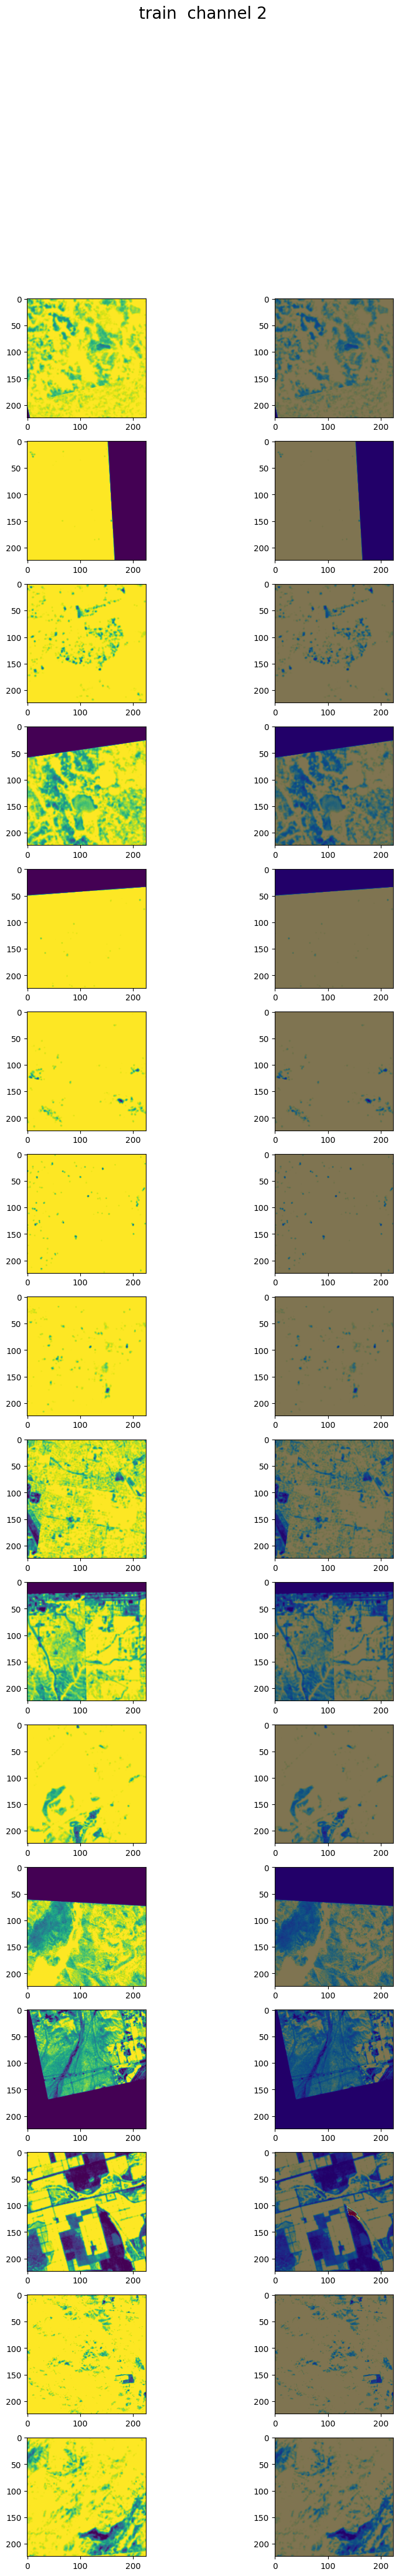

In [17]:

# Let's plot some images
def draw_transforms(batch_img, batch_size, ch, caption:str):
  x, y = batch_img
  fig, axes = plt.subplots(batch_size, 2, figsize=(10,50))
  fig.suptitle(f"{caption}  channel {ch}", fontsize=20)
  for i in range(batch_size):
      axes[i,0].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).numpy())
      axes[i,1].imshow(x[i,ch].view(_INPUT_SIZE,_INPUT_SIZE,1).numpy())
      axes[i,1].imshow(y[i].view(_INPUT_SIZE,_INPUT_SIZE,1).numpy(), cmap='jet', alpha=0.5)
  plt.show()

draw_transforms(processed_img, _BATCH_SIZE, 2, "train")

In [ ]:
idx, test_img = next(enumerate(test_loadr))

In [ ]:
draw_transforms(test_img, _BATCH_SIZE, 0, "test")

## Використовуємо за Loss Combined BCE + F1 (Dice loss)

## Метрики - попіксельно F1/AuC та Extended IoU

Покращений IoU враховує відстань між масками і ground truth навіть за нульового перекриття, уникає плато нульового градієнту.

In [19]:
def write_results(results_file, results, format='csv'):
    with open(results_file, mode='w') as cf:
        if format == 'json':
            json.dump(results, cf, indent=4)
        else:
            if not isinstance(results, (list, tuple)):
                results = [results]
            if not results:
                return
            dw = csv.DictWriter(cf, fieldnames=results[0].keys())
            dw.writeheader()
            for r in results:
                dw.writerow(r)
            cf.flush()

def get_outdir(path, *paths, inc=False):
    outdir = os.path.join(path, *paths)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    elif inc:
        count = 1
        outdir_inc = outdir + '-' + str(count)
        while os.path.exists(outdir_inc):
            count = count + 1
            outdir_inc = outdir + '-' + str(count)
            assert count < 100
        outdir = outdir_inc
        os.makedirs(outdir)
    return outdir

def update_summary(epoch, train_metrics, eval_metrics, filename, write_header=False, log_wandb=False):
    rowd = OrderedDict(epoch=epoch)
    rowd.update([('train_' + k, v) for k, v in train_metrics.items()])
    rowd.update([('eval_' + k, v) for k, v in eval_metrics.items()])
    # if log_wandb:
    #     wandb.log(rowd)
    with open(filename, mode='a') as cf:
        dw = csv.DictWriter(cf, fieldnames=rowd.keys())
        if write_header:  # first iteration (epoch == 1 can't be used)
            dw.writeheader()
        dw.writerow(rowd)

In [ ]:
class WeightedFocalLoss(nn.Module):

  def __init__(self, alpha, gamma=2):
      super(WeightedFocalLoss, self).__init__()
      self.alpha = alpha
      self.gamma = gamma

  def forward(self, inputs, targets):

      BCE_loss = F.nll_loss(inputs, targets, reduction='none')
      targets = targets.type(torch.long)
      # at = self.alpha.gather(0, targets.data.view(-1))
      pt = torch.exp(-BCE_loss)
      F_loss = self.alpha[targets]*(1-pt)**self.gamma * BCE_loss
      loss_weighted_manual = F_loss.sum() / self.alpha[targets].sum()
      return loss_weighted_manual

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, weights=None, smooth=1):

        #In case of lack of sigmoid activation
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        if weights:
          assert weights.shape == inputs.shape
          dice_loss = dice_loss * weights
        BCE = F.binary_cross_entropy(inputs, targets, weight=weights, reduction='mean')
        Dice_BCE = BCE + dice_loss
        # Element-wise multiplication per weight
        if weights:
          assert weights.shape == inputs.shape
          Dice_BCE = Dice_BCE * weights
        return Dice_BCE

### Не використовується як лосс, а як метрика для порівняння результатів

In [14]:
class IoU(nn.Module):
    def __init__(self, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):


        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

### Додамо ваги класів в лосс для урахування дизбалансу.

In [15]:
### Class imbalance (sometimes a few pixels against a backdrop of a single class)
### Should be solved by applying weight for error on each class by its size

def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y.view(-1))
    return list(map(lambda x: total_samples / len(unique_classes) / class_counts[x], unique_classes))

In [ ]:
#class_weights = torch.tensor(calculate_class_weights(y_train), dtype=torch.float, device=device)

In [ ]:
for i in range(100):
    pos_weight = torch.randint(1, 100, (1,)).float()

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    x = torch.randn(10, 1, requires_grad=True)
    y = torch.randint(0, 2, (10, 1)).float()

    loss = criterion(x, y)

    criterion_raw = nn.BCEWithLogitsLoss(reduction='none')
    loss_raw = criterion_raw(x, y)
    weight = torch.ones_like(loss_raw)
    weight[y==1.] = pos_weight
    loss_raw = (loss_raw * weight).mean()

    criterion_raw_sig = nn.BCELoss(reduction='none')
    loss_raw_sig = criterion_raw_sig(torch.sigmoid(x), y)
    loss_raw_sig = ((loss_raw_sig) * weight).mean()

    print(loss - loss_raw)
    print(loss_raw_sig - loss)

### Check forward pass

In [ ]:
# Create dummy data
batch_size, height, width = 1, 224, 224
pre_fire = torch.randn(batch_size, 3, height, width)
post_fire = torch.randn(batch_size, 3, height, width)
edge_image = torch.randn(batch_size, 3, height, width)

# Initialize the network
model = SegmentationNetwork(num_clusters=6, input_channels=9)

# Forward pass
segmentation_mask = model(pre_fire, post_fire, edge_image)

# Print the output shape
print("Segmentation Mask Shape:", segmentation_mask.shape)

# Пайплайн тренування і валідації

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]



In [ ]:
def loss(model,
         loss_func,
         X, y,
         weights=None,
         optimizer=None
):
    loss_ = loss_func(model(X), y, weights)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), X.size(0)

In [ ]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
#_logger = logging.getlogger('validate')
utils.setup_default_logging()
def validate(
        model,
        loader,
        loss_fn,
        metric,
        device=torch.device('cuda'),
        results_file='/',
        log_suffix='',
        log_frequency=10
):
    batch_time_m = utils.AverageMeter()
    losses_m = utils.AverageMeter()
    top1_m = utils.AverageMeter()
    top5_m = utils.AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx
            input = input.to(device)
            target = target.to(device)
            # if channels_last:
                # input = input.contiguous(memory_format=torch.channels_last)

            output = model(input)
            if isinstance(output, (tuple, list)):
                output = output[0]

                # augmentation reduction
                # reduce_factor = args.tta
                # if reduce_factor > 1:
                #     output = output.unfold(0, reduce_factor, reduce_factor).mean(dim=2)
                #     target = target[0:target.size(0):reduce_factor]

                loss = loss_fn.forward(output, target)
            acc1, acc5 = accuracy(output, target, topk=(1, 5))

            # if args.distributed:
            #     reduced_loss = utils.reduce_tensor(loss.data, args.world_size)
            #     acc1 = utils.reduce_tensor(acc1, args.world_size)
            #     acc5 = utils.reduce_tensor(acc5, args.world_size)
            # else:
            # reduced_loss = loss.data

            if device.type == 'cuda':
                torch.cuda.synchronize()
            elif device.type == "npu":
                torch.npu.synchronize()

            losses_m.update(loss, input.size(0))
            top1_m.update(acc1, output.size(0))
            top5_m.update(acc5, output.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()
            if last_batch or batch_idx % log_frequency == 0:
                log_name = 'Test' + log_suffix
                # _logger.info(
                #     f'{log_name}: [{batch_idx:>4d}/{last_idx}]  '
                #     f'Time: {batch_time_m.val:.3f} ({batch_time_m.avg:.3f})  '
                #     f'Loss: {losses_m.val:>7.3f} ({losses_m.avg:>6.3f})  '
                #     f'Acc@1: {top1_m.val:>7.3f} ({top1_m.avg:>7.3f})  '
                #     f'Acc@5: {top5_m.val:>7.3f} ({top5_m.avg:>7.3f})'
                # )

    metrics = OrderedDict([('loss', losses_m.avg), ('top1', top1_m.avg), ('top5', top5_m.avg)])
    if results_file:
        write_results(results_file, metrics)
    print(f'--result\n{json.dumps(metrics, indent=4)}')
    return metrics

In [ ]:
def fit(epochs,
        model,
        loss_func,
        optimizer,
        train_loader,
        valid_loader,
        lr_scheduler,
        patience=10
):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.inf

    for epoch in tqdm(range(epochs)):

        model.train()
        running_loss = 0.
        losses = []
        for X, y in train_loader:
          weight = calculate_class_weights(y)
          losses.append(loss(model, loss_func, X, y, weight, optimizer))
          #running_loss += losses[-1] * X.size(0)

        #epoch_loss = running_loss / len(train_loader)

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        if lr_scheduler is not None:
            lr_scheduler.step()

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              # TODO
              ################################################
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, top1, top5, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100
            # TODO
            ##################################################
            #valid_f1 =
            #valid_IoU =
            #valid_KLD =
            #valid_Focal =

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [ ]:
def train(model, criterion, metric, optimizer, n_epochs, transforms, input_size=512,
          batch=64, saving_model_path=None, lr_scheduler=None):

    train_dataset = CaBuArPyTorchDataset(
    hf_dataset=   train_data,
    transform=get_transforms(input_size)),
    augment=augmentation
    valid_dataset = test_dataset = CaBuArPyTorchDataset(
    hf_dataset=   valid_data,
    transform=get_transforms(input_size)),
    augment=augmentation
    test_dataset = CaBuArPyTorchDataset(
    hf_dataset=   test_data,
    transform=transforms.RandomCrop(size=_INPUT_SIZE, pad_if_needed=True))

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=batch, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=batch, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=batch, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    loss_record = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader, lr_scheduler)
    # l, acc = 0., 0.
    # _, l, acc = losses_arr[-1]
    t = time.time() - start_time
    print(f'Fit time: {t} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    validate(model, test_loader, criterion, metric, device=device,
                      results_file=saving_model_path)

    # stat_loss.append(l)
    # stat_acc.append(acc)
    # stat_t.append(t)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path(saving_model_path))

    # training_plots(losses_arr)

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# Old weights with accuracy 76.130%
weight = FCN_ResNet50_Weights.DEFAULT
print(weight.meta['categories'])
base_model = fcn_resnet50(weights=weight)



In [27]:
list(base_model.children())

[IntermediateLayerGetter(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256

In [53]:
idx, (X_test, y) = next(enumerate(vd_loadr))

Done for id 30, torch.Size([4, 224, 224])

Done for id 39, torch.Size([4, 224, 224])

Done for id 19, torch.Size([4, 224, 224])

Done for id 36, torch.Size([4, 224, 224])

Done for id 0, torch.Size([4, 224, 224])

Done for id 2, torch.Size([4, 224, 224])

Done for id 42, torch.Size([4, 224, 224])

Done for id 12, torch.Size([4, 224, 224])

Done for id 14, torch.Size([4, 224, 224])

Done for id 29, torch.Size([4, 224, 224])

Done for id 6, torch.Size([4, 224, 224])

Done for id 41, torch.Size([4, 224, 224])

Done for id 26, torch.Size([4, 224, 224])

Done for id 59, torch.Size([4, 224, 224])

Done for id 11, torch.Size([4, 224, 224])

Done for id 63, torch.Size([4, 224, 224])

Done for id 27, torch.Size([4, 224, 224])

Done for id 23, torch.Size([4, 224, 224])

Done for id 50, torch.Size([4, 224, 224])

Done for id 1, torch.Size([4, 224, 224])

Done for id 15, torch.Size([4, 224, 224])

Done for id 45, torch.Size([4, 224, 224])

Done for id 52, torch.Size([4, 224, 224])

Done for id 40,

In [52]:
X_test = X_test.to(device)
for param in base_model.parameters():
    param.requires_grad = False
output = base_model.backbone(X_test)

In [25]:
print([(k, v.shape) for k, v in output.items()])

[('aux', torch.Size([16, 1024, 28, 28])), ('out', torch.Size([16, 2048, 28, 28]))]


In [54]:
class CustomModel(nn.Module):
    def __init__(self, feature_extractor, num_classes):
        super(CustomModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.head = [nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.ReLU(),
                    nn.Dropout(p=0.1, inplace=False),
                    nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))]
                    # Adjust the input size based on the feature extractor's output

    def forward(self, x):
        features = self.feature_extractor(x)['aux']
        for layer in self.head:
          features = layer(features)
        return output

In [55]:
test_model = CustomModel(base_model.backbone, 1)
output = test_model(X_test)


In [56]:
print([(k, v.shape) for k, v in output.items()])

[('aux', torch.Size([16, 1024, 28, 28])), ('out', torch.Size([16, 2048, 28, 28]))]


In [ ]:
criterion = DiceBCELoss()
optimizer = torch.ptim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.3)
res = validate(base_model, vd_loadr, criterion, device=device)